# Exercise 8.1
## Sinus forecasting
In this task, we will learn to implement RNNs in Keras.
Therefore:
 - Run the provided script and comment on the output.
 - Vary the number and size of the LSTM layers and compare training time and stability of the performance. 

The goal of this task is to predict the next value of a sine function. This is a special case because the output of the network (the `y` value) should correponds to the next input `x` value. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers

print(keras.__version__)

2.9.0


### Generation of data
We start by creating a signal trace: `t = 0-100`, `f = sin(pi * t)`

In [3]:
N = 10000
t = np.linspace(0, 100, N)  # time steps
f = np.sin(np.pi * t)  # signal

Split into semi-redundant sub-sequences of `length = window_size + 1` and perform shuffle

In [4]:
window_size = 20
n = N - window_size - 1  # number of possible splits
print(n)
print(f"generating {n} semi redundant sub-sequences with size {window_size+1}.")
data = np.stack([f[i: i + window_size + 1] for i in range(n)])
print(data.shape)

9979
generating 9979 semi redundant sub-sequences with size 21.
(9979, 21)


Finally, split the data into features. The `x` values are the first 20 data points of a sequence. The `y` value is the corresponding next value in the sequence. 

In [5]:
X, y = np.split(data, [-1], axis=1)

# as always, another dimension is added to the input vector 
# because the KERAS library also allows for multiple inputs per time step. 
# In our case here, we have just one input value per time stamp.
X = X[..., np.newaxis] # WTF ?
print(X.shape)
print(y.shape)
print('Example:')
print('X =', X[0, :, 0])
print('y =', y[0, :])

(9979, 20, 1)
(9979, 1)
Example:
X = [0.         0.0314139  0.06279679 0.0941177  0.1253457  0.15644998
 0.18739983 0.21816471 0.24871423 0.27901826 0.30904688 0.33877044
 0.36815961 0.39718538 0.42581909 0.45403249 0.48179773 0.50908739
 0.53587454 0.56213275]
y = [0.58783609]


### Define and train RNN

In [75]:
z0 = layers.Input(shape=[None, 1])
z = layers.LSTM(5)(z0) # return_sequences=True !
#z = layers.LSTM(10, return_sequences=True)(z)
#z = layers.LSTM(10, return_sequences=True)(z)
#z = layers.LSTM(10, return_sequences=True)(z)
#z = layers.LSTM(10, return_sequences=True)(z)
#z = layers.LSTM(10, return_sequences=True)(z)
#z = layers.LSTM(10, return_sequences=True)(z)
#z = layers.LSTM(10, return_sequences=True)(z)
#z = layers.LSTM(10, return_sequences=True)(z)
#z = layers.LSTM(10)(z)
z = layers.Dense(1)(z)
model = keras.models.Model(inputs=z0, outputs=z)
print(model.summary())

model.compile(loss='mse', optimizer='adam')

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, None, 1)]         0         
                                                                 
 lstm_34 (LSTM)              (None, 5)                 140       
                                                                 
 dense_13 (Dense)            (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
results = model.fit(X, y,
    epochs=60,
    batch_size=32,
    verbose=2,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(factor=0.67, patience=3, verbose=1, min_lr=1E-5),
        keras.callbacks.EarlyStopping(patience=4, verbose=1)])

Epoch 1/60
281/281 - 3s - loss: 0.0366 - val_loss: 0.0080 - lr: 0.0010 - 3s/epoch - 12ms/step
Epoch 2/60
281/281 - 1s - loss: 0.0040 - val_loss: 0.0023 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 3/60
281/281 - 1s - loss: 0.0016 - val_loss: 9.2423e-04 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 4/60
281/281 - 1s - loss: 4.7049e-04 - val_loss: 2.2425e-04 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 5/60
281/281 - 1s - loss: 1.6400e-04 - val_loss: 1.2386e-04 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 6/60
281/281 - 1s - loss: 9.7509e-05 - val_loss: 7.7955e-05 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 7/60
281/281 - 1s - loss: 6.4815e-05 - val_loss: 5.6605e-05 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 8/60

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
281/281 - 1s - loss: 4.3428e-05 - val_loss: 3.3599e-05 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 9/60
281/281 - 1s - loss: 3.0493e-05 - val_loss: 2.5778e-05 - lr: 6.7000e-04 - 1s/epoch - 4ms/step
Epoch 10/60
281/281 - 1s - lo

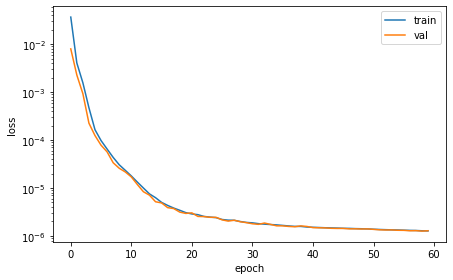

In [77]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.tight_layout()

### Evaluate the model
Investigate the forecasting capabilities of the model.

In [78]:
def predict_next_k(model, window, k=10):
    """Predict next k steps for the given model and starting sequence """
    x = window[np.newaxis, :, np.newaxis]  # initial input
    y = np.zeros(k)
    for i in range(k):
        y[i] = model.predict(x, verbose=0)
        # create the new input including the last prediction
        x = np.roll(x, -1, axis=1)  # shift all inputs 1 step to the left
        x[:, -1] = y[i]  # add latest prediction to end
    return y

In [79]:
def plot_prediction(i0=0, k=500):
    """ Predict and plot the next k steps for an input starting at i0 """
    y0 = f[i0: i0 + window_size]  # starting window (input)
    y1 = predict_next_k(model, y0, k)  # predict next k steps

    t0 = t[i0: i0 + window_size]
    t1 = t[i0 + window_size: i0 + window_size + k]

    plt.figure(figsize=(12, 4))
    plt.plot(t, f, label='data')
    plt.plot(t0, y0, color='C1', lw=3, label='prediction')
    plt.plot(t1, y1, color='C1', ls='--')
    plt.xlim(0, 10)
    plt.legend()
    plt.xlabel('$t$')
    plt.ylabel('$f(t)$')

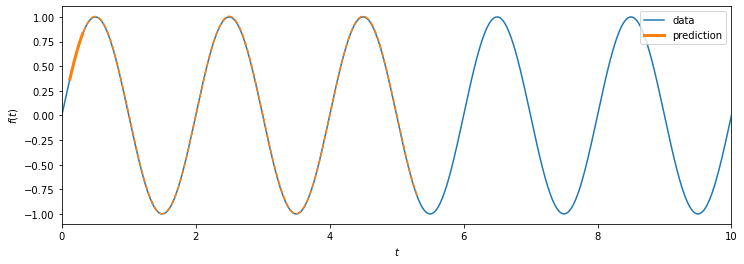

In [80]:
plot_prediction(12)

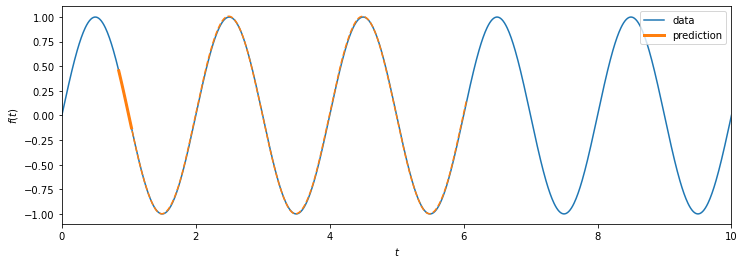

In [81]:
plot_prediction(85)

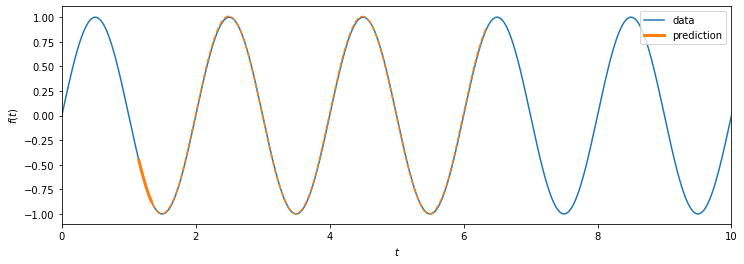

In [82]:
plot_prediction(115)

## Comments 1: overall LSTM principle

The LSTM network uses 20 inputs, that a window of 20 time-series samples, to predict the t = (20 + 1)th sample of the time serie. The next prediction (22th sample) will then include the previous prediction in its input.

The big advantage of the type of prediction is that doesn't need any state of the system at any time to give prediction. "Only" requirement is the past 20 time serie samples, whcih can be an advantage of some physical based model that would require numerous intital states which cannot necessaraly be known at a specific time.

## Comments 2: changing size

For the different tests, the number of layer is kept constant with 1 layer.
After testing several network size (5, 16, 32 and 100 nodes), one can notice the following observations:

* the training and prediction time varies varies only slightly between the test, where it increases with number of nodes.
* loss convergence is reached faster when the number of nodes increases
* loss tends to decrease with the number of node

However, each run is unique (due to weight initialization ?) and various, surprising result has been obtained for the same run... leading to counter intuitive results, like the best stabilization observed for a network with 5 nodes, with perfect fidelity observed when looking at the plot.

Also, for most of the try, pretty much independently of the node number, a lack of accuracy (fidelity) started to appear after 2 or 3 periods, that could, for longer prediction, end up as stability problem...

## Comments 3: changing layers number

For the different tests, the size of each layer is kept constant with 10 nodes. We vary the number of layer (1, 2, 3 and 10), one can notice only the following observation:

* the training and prediction time varies varies fairly between the test, where it increases with number of layers.
* loss convergence is reached faster when the number of layers increases

Other characteristics, like loss and stability are very hard to interprete in relation with the number of layers... However, for 10 layers, stability was lost after 1 period only, leading to huge errors... The network with 2 and 3 layers obtained similar loss, but higher than one layer. One coul conclude that a balance should be found in terms of layer number in order to decrease the loss but avoid early unstability.